# Loan Default Prediction Notebook


## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import shap
import warnings
warnings.filterwarnings("ignore")

## 2. Load Data

In [ ]:
df = pd.read_csv("DOC-20250712-WA0001.csv")
print("Shape:", df.shape)
df.head()

Shape: (9120, 142)


,id,merchant_id,funded_at,type,status,iso_coms_amount,iso_coms_perc,principal_amount,factor_rate,payback_amount,...,total_num_days_with_nsf,total_balance,total_credit,true_credit,mean_days_negative,mean_num_days_with_nsf,mean_total_credit,mean_true_credit,mean_daily_balance,frequency
0,397654,231859,6/11/2020,new,"Closed, Paid",11250.0,5.00,225000.0,1.29,290250.0,...,7.0,48992940.05,14338390.06,13769609.80,0.571429,0.538462,5.120854e+05,4.917718e+05,83892.020630,daily
1,399496,233158,5/20/2020,new,"Closed, Paid",22470.0,11.24,200000.0,1.49,298000.0,...,2.0,21184955.92,4681994.01,4371497.22,4.888889,0.333333,5.202216e+05,4.857219e+05,113288.534300,daily
2,400523,233702,5/18/2020,new,Completed With Discount,14580.0,9.72,150000.0,1.36,204000.0,...,0.0,50325475.08,7555691.94,6741402.74,0.000000,0.000000,1.888923e+06,1.685351e+06,592064.412700,weekly
3,400990,233956,5/22/2020,new,"Closed, Paid",7142.0,8.93,80000.0,1.37,109600.0,...,0.0,3269037.02,1304541.79,1218741.79,0.000000,0.000000,1.630677e+05,1.523427e+05,19575.071980,daily
4,401006,233023,5/19/2020,new,"Closed, Paid",1336.0,6.68,20000.0,1.34,26800.0,...,2.0,2148772.37,588175.89,195062.81,0.052632,0.105263,3.095663e+04,1.026646e+04,5385.394411,daily


## 3. Define Target and Drop Irrelevant Columns

In [ ]:
df = df.copy()
df['default_ind'] = df['default_ind'].fillna(0)
y = df['default_ind']
X = df.drop(columns=['id', 'default_ind', 'status', 'funded_at', 'defaulted_at', 'default_date_min', 'default_date_max'])

## 4. Identify Column Types

In [ ]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

## 5. Preprocessing Pipelines

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

## 6. Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 7. Define Models

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

## 8. Evaluation Function

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


## 9. Train and Evaluate All Models


Logistic Regression Results:

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1060
           1       1.00      0.95      0.97       764

    accuracy                           0.98      1824
   macro avg       0.98      0.97      0.98      1824
weighted avg       0.98      0.98      0.98      1824

Confusion Matrix:
 [[1059    1]
 [  40  724]]
ROC-AUC: 0.9851402746221476


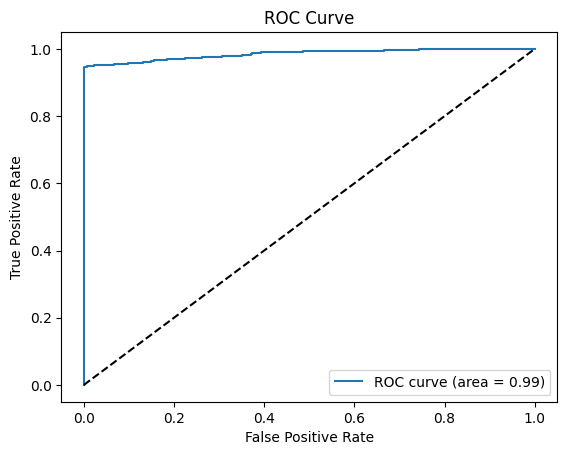


Random Forest Results:

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1060
           1       1.00      0.90      0.95       764

    accuracy                           0.96      1824
   macro avg       0.97      0.95      0.95      1824
weighted avg       0.96      0.96      0.96      1824

Confusion Matrix:
 [[1060    0]
 [  79  685]]
ROC-AUC: 0.986202212782772


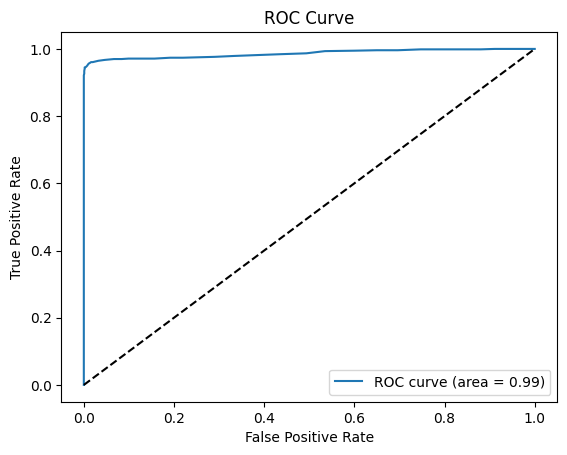


XGBoost Results:

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1060
           1       0.99      0.96      0.97       764

    accuracy                           0.98      1824
   macro avg       0.98      0.98      0.98      1824
weighted avg       0.98      0.98      0.98      1824

Confusion Matrix:
 [[1053    7]
 [  32  732]]
ROC-AUC: 0.9918687642003359


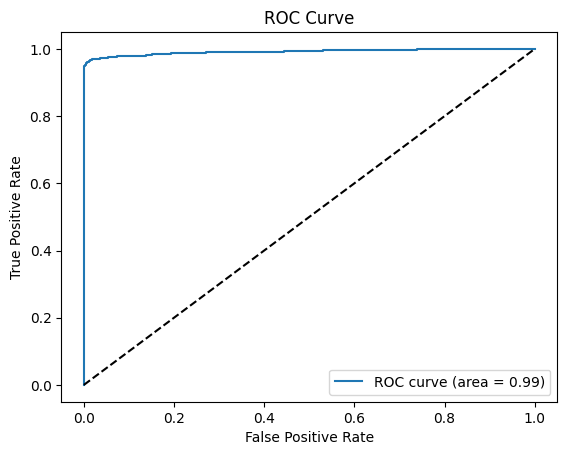


LightGBM Results:
[LightGBM] [Info] Number of positive: 3055, number of negative: 4241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14482
[LightGBM] [Info] Number of data points in the train set: 7296, number of used features: 844
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.418723 -> initscore=-0.328019
[LightGBM] [Info] Start training from score -0.328019

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1060
           1       0.99      0.95      0.97       764

    accuracy                           0.98      1824
   macro avg       0.98      0.97      0.98      1824
weighted avg       0.98      0.98      0.98      1824

Confusion Matrix:
 [[1053    7]
 [  35  729]]
ROC-AUC: 0.990895732490368

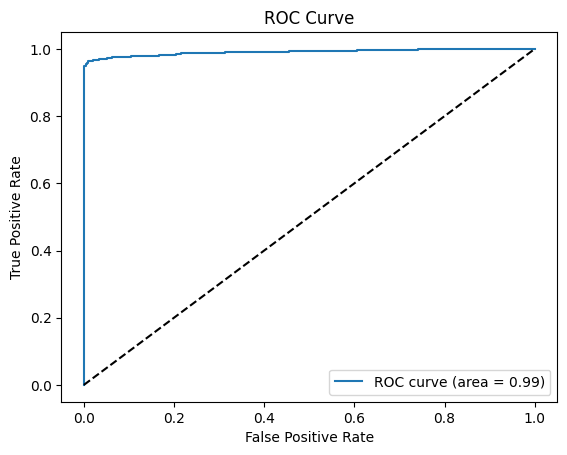


CatBoost Results:

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1060
           1       1.00      0.95      0.97       764

    accuracy                           0.98      1824
   macro avg       0.98      0.97      0.98      1824
weighted avg       0.98      0.98      0.98      1824

Confusion Matrix:
 [[1060    0]
 [  40  724]]
ROC-AUC: 0.9907574335671243


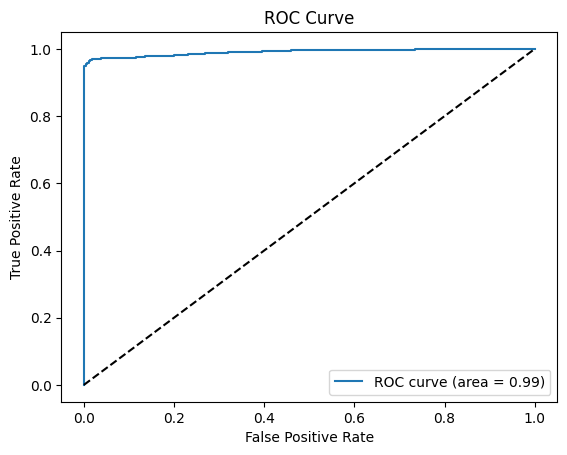

In [ ]:
for name, model in models.items():
    print(f"\n{name} Results:")
    evaluate_model(model, X_train, X_test, y_train, y_test)

## 10. Cross Validation Summary

In [ ]:
for name, model in models.items():
  pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('classifier', model)
  ])
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
  print(f"\n{name} CV ROC-AUC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")


Logistic Regression CV ROC-AUC: 0.9888 ± 0.0022

Random Forest CV ROC-AUC: 0.9885 ± 0.0034

XGBoost CV ROC-AUC: 0.9926 ± 0.0017
[LightGBM] [Info] Number of positive: 3056, number of negative: 4240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14459
[LightGBM] [Info] Number of data points in the train set: 7296, number of used features: 847
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.418860 -> initscore=-0.327456
[LightGBM] [Info] Start training from score -0.327456
[LightGBM] [Info] Number of positive: 3055, number of negative: 4241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14449
[LightGBM] [Info] Number of data points in the t

## 11. Feature Importance (for XGBoost)

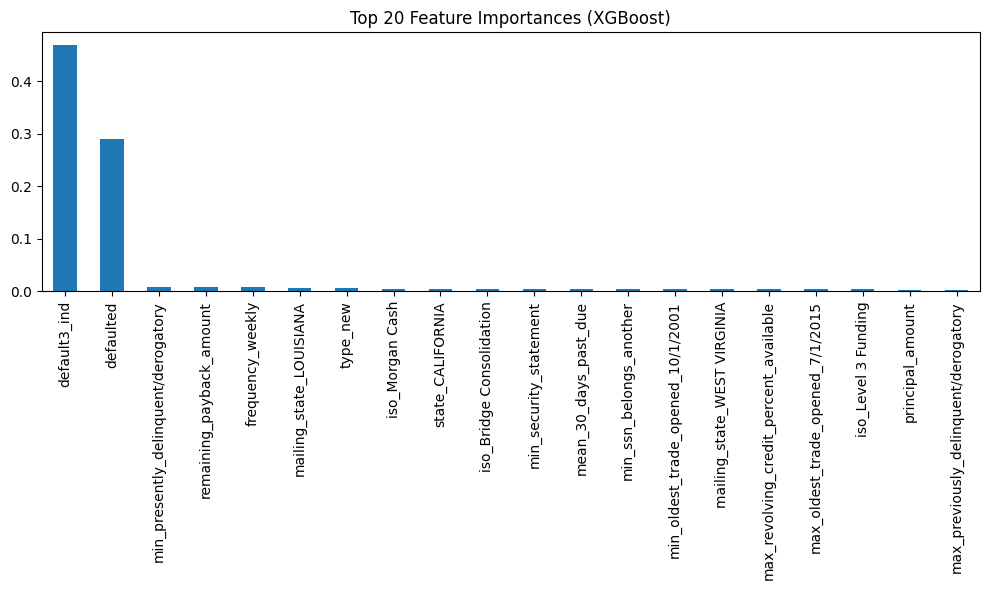

In [ ]:
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_model.fit(X_train, y_train)
feat_names = xgb_model.named_steps['preprocessor'].transformers_[0][2] + \
             list(xgb_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
importances = xgb_model.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
feat_imp.plot(kind='bar')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

## 12. SHAP Analysis (optional, only on small sample for speed)


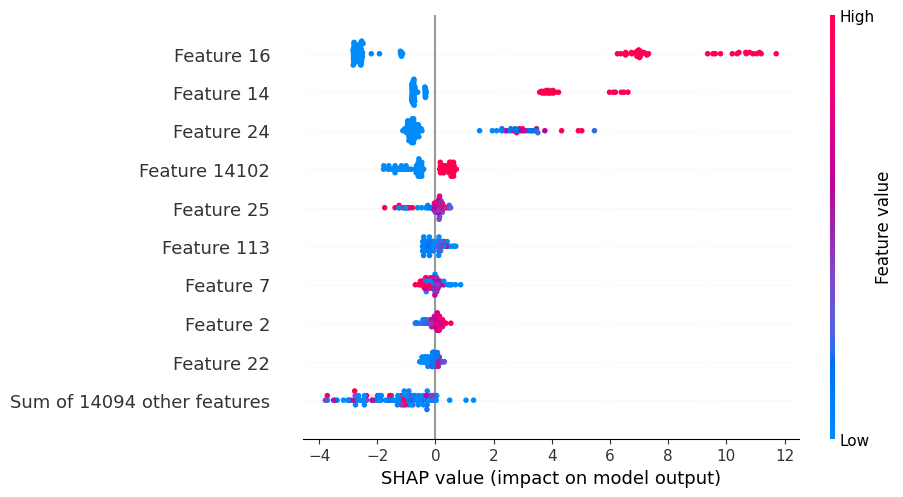

In [ ]:
explainer = shap.Explainer(xgb_model.named_steps['classifier'])
X_transformed = xgb_model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer(X_transformed[:100])
shap.plots.beeswarm(shap_values)